In [14]:
import hopsworks
import base64
import io
import os

from PIL import Image
import pandas as pd

In [11]:
project = hopsworks.login()
mr = project.get_model_registry()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://snurran.hops.works/p/13431
Connected. Call `.close()` to terminate connection gracefully.


In [12]:
model = mr.get_model("transchex")

In [90]:
%%writefile transchex_predictor.py
import os
import base64

from transformers import BertTokenizer
from torchvision import transforms
from PIL import Image

from monai.networks.nets import Transchex

### Changes to run on Gaudi
# import sys
# sys.path
# sys.path.append('/usr/local/lib/python3.10/dist-packages')
import torch

# - Import habana libraries
# import habana_frameworks.torch.gpu_migration
# import habana_frameworks.torch.core as htcore

class Predict(object):

    def __init__(self):
        """ Initializes the serving state, reads a trained model"""        
        # Load the trained model
        device = torch.device('cuda')
        
        self.model = Transchex(
            in_channels=3,
            img_size=(256, 256),
            num_classes=14,
            patch_size=(32, 32),
            num_language_layers=2,
            num_vision_layers=2,
            num_mixed_layers=2,
        ).to(device)
        
        self.model.load_state_dict(torch.load(f"{os.environ['ARTIFACT_FILES_PATH']}/transchex.pt", map_location = device)["state_dict"])
        self.model.eval()
        
        # Load Tokenizer for the report
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=False)
        
        # Load Preprocess for the Xray Image
        self.preprocess = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            ]
        )
        
        print("Initialization Complete")

    def predict(self, inputs):
        image, input_ids, segment_ids = self._handle_inputs(inputs)
        print(type(image))
        with torch.no_grad():
            logits_lang = self.model(input_ids=input_ids, vision_feats=image, token_type_ids=segment_ids)
            prob = torch.sigmoid(logits_lang)[0]
            
            return {
                'atelectasis': prob[0].item(),
                'cardiomegaly': prob[1].item(),
                'consolidation': prob[2].item(),
                'edema': prob[3].item(),
                'enlarged_cardiomediastinum': prob[4].item(),
                'fracture': prob[5].item(),
                'lung_lesion': prob[6].item(),
                'lung_opacity': prob[7].item(),
                'no_finding': prob[8].item(),
                'pleural_effusion': prob[9].item(),
                'pleural_other': prob[10].item(),
                'pneumonia': prob[11].item(),
                'pneumothorax': prob[12].item(),
                'support_devices': prob[13].item()
            }
        
    def _handle_inputs(self, inputs):
        """Deserialize the input"""
        image = Image.frombytes(mode="RGB", size=(512, 512), data=base64.b64decode(inputs[0]["image"]))
        image_preprocessed = self.preprocess(image).unsqueeze(0).cuda()
        
        input_ids, segment_ids = self._encode_report_features(inputs[0]["report"], 512)
        
        return image_preprocessed, input_ids, segment_ids 
          
    def _encode_report_features(self, sent, max_seq_length):
        tokens = self.tokenizer.tokenize(sent.strip())
        if len(tokens) > max_seq_length - 2:
            tokens = tokens[: (max_seq_length - 2)]
        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        segment_ids = [0] * len(input_ids)
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            segment_ids.append(0)
        assert len(input_ids) == max_seq_length
        assert len(segment_ids) == max_seq_length
        
        # Wrap it into a torch tensor
        input_ids = torch.tensor([input_ids], dtype=torch.long).cuda()
        segment_ids = torch.tensor([segment_ids], dtype=torch.long).cuda()
        
        return input_ids, segment_ids

Overwriting transchex_predictor.py


In [91]:
# Get the dataset API for the current project
dataset_api = project.get_dataset_api()

# Specify the local file path of the Python script to be uploaded
local_script_path = "transchex_predictor.py"

# Upload the Python script to the "Models", and overwrite if it already exists
uploaded_file_path = dataset_api.upload(local_script_path, f"Models/{model.name}/{model.version}", overwrite=True)

# Create the full path to the uploaded script for future reference
predictor_script_path = os.path.join("/Projects", project.name, uploaded_file_path)

Uploading: 0.000%|          | 0/3919 elapsed<00:00 remaining<?

In [92]:
predictor_script_path

'/Projects/monai/Models/transchex/1/transchex_predictor.py'

In [93]:
from hsml.resources import PredictorResources, Resources

minimum_res = Resources(cores=2, memory=6000, gpus=1)
maximum_res = Resources(cores=2, memory=6000, gpus=1)

resources = PredictorResources(num_instances=1, requests=minimum_res, limits=maximum_res)

In [94]:
deployment = model.deploy(
    name="transchex",
    script_file=predictor_script_path,
    resources=resources
)

Deployment created, explore it at https://snurran.hops.works/p/13431/deployments/11274
Before making predictions, start the deployment by using `.start()`


In [95]:
deployment.start(await_running=600)

  0%|          | 0/5 [00:00<?, ?it/s]

Start making predictions by using `.predict()`


In [119]:
# TODO - Fix this path so that it matches the dataset in Hopsworks with the raw data for the XRay PNG Images
# See the training notebook for reference
image_dir = f"{os.environ['JUPYTER_PATH']}/source_data/NLMCXR_png"

In [120]:
# TODO - Fix this path so that it points to the test data for the Monai training dataset
# See the training notebook for reference
test_data = pd.read_csv(f"{os.environ['JUPYTER_PATH']}/monai_Training_Datasets/trans_che_x_1_1/test/part-00000-ebb87065-8a51-49c9-9b4d-dc51066a1ab6-c000.csv")

In [121]:
test_example = test_data[test_data['fracture'] == 1].iloc[1]

In [122]:
test_example

atelectasis                                                                   0
cardiomegaly                                                                  0
consolidation                                                                 0
edema                                                                         0
enlarged_cardiomediastinum                                                    0
fracture                                                                      1
lung_lesion                                                                   0
lung_opacity                                                                  0
no_finding                                                                    0
pleural_effusion                                                              0
pleural_other                                                                 0
pneumonia                                                                     0
pneumothorax                            

In [123]:
image_address = f"{image_dir}/{test_example['xray_png']}"

In [124]:
image = Image.open(image_address).resize((512, 512))
report = test_example['report']

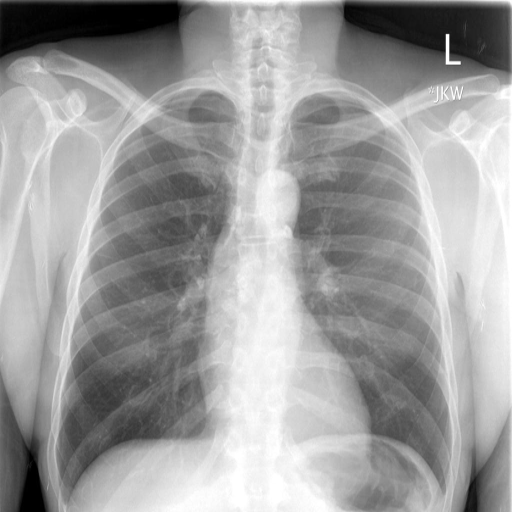

In [125]:
image

In [126]:
report

'FINDINGS :  IMPRESSION : Heart size normal. Lungs are clear. Calcified mediastinal and hilar lymph XXXX unchanged. Old XXXX fracture deformity of approximately T6.'

In [118]:
deployment.predict(inputs=[{'report': report, 'image': base64.b64encode(image.tobytes()).decode('utf-8')}])

{'predictions': {'atelectasis': 0.0082616051658988,
  'cardiomegaly': 0.031622469425201416,
  'consolidation': 0.01111145131289959,
  'edema': 0.0022585326805710793,
  'enlarged_cardiomediastinum': 0.03022688627243042,
  'fracture': 0.18040359020233154,
  'lung_lesion': 0.0027619015891104937,
  'lung_opacity': 0.007474851328879595,
  'no_finding': 0.34138762950897217,
  'pleural_effusion': 0.011977818794548512,
  'pleural_other': 0.011982565745711327,
  'pneumonia': 0.005972424056380987,
  'pneumothorax': 0.007417305838316679,
  'support_devices': 0.35802286863327026}}